# Capstone Project - Short Answer Grading

## SciEntsBank Data and Modeling

In [141]:
# source code for SKLearn custom train.py
!pygmentize source/train.py

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import argparse
import os
import sys
import pandas as pd

from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Embedding, LSTM, Dropout, Dense, Flatten, Reshape
from tensorflow.python.training.adam import AdamOptimizer

if __name__ == '__main__':
    # All of the model parameters and training parameters are sent as arguments
    # when this script is executed, during a training job

    # Here we set up an argument parser to easily access the parameters
    parser = argparse.ArgumentParser()

    # SageMaker parameters, like the directories for training data and saving models; set automatically
    # Do not need to change
    parser.add_argument('--output-data-dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    parser.add_argument('--data-dir', type=str, default=os.environ['SM_CHANNEL_TRAINING'])
    parser.add_argument('--model_dir'

# Setup AWS

In [22]:
import pandas as pd
import os
import numpy as np

# should be the name of directory you created to save your features data
data_dir = 'data/seb'

In [3]:
import boto3
import sagemaker

# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [ ]:
# set prefix, a descriptive name for a directory  
prefix = 'sagemaker/short_answer'

# upload all data to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

## Analyzing Source Data

In [27]:
raw_data = pd.read_csv(os.path.join(data_dir, "raw_data.csv"))
train_data = pd.read_csv(os.path.join(data_dir, "train.csv"), header=None, names=None)
test_data = pd.read_csv(os.path.join(data_dir, "test.csv"), header=None, names=None)
vocab = pd.read_csv(os.path.join(data_dir, "vocab.csv"), header=None, names=None)

In [15]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 5 columns):
answer              140 non-null object
correct             140 non-null int64
question            140 non-null object
reference_answer    140 non-null object
answer_length       140 non-null int64
dtypes: int64(2), object(3)
memory usage: 5.5+ KB


In [26]:
len(vocab)

234

In [29]:
raw_data['answer_length'] = raw_data['answer'].apply(lambda x: len(x))

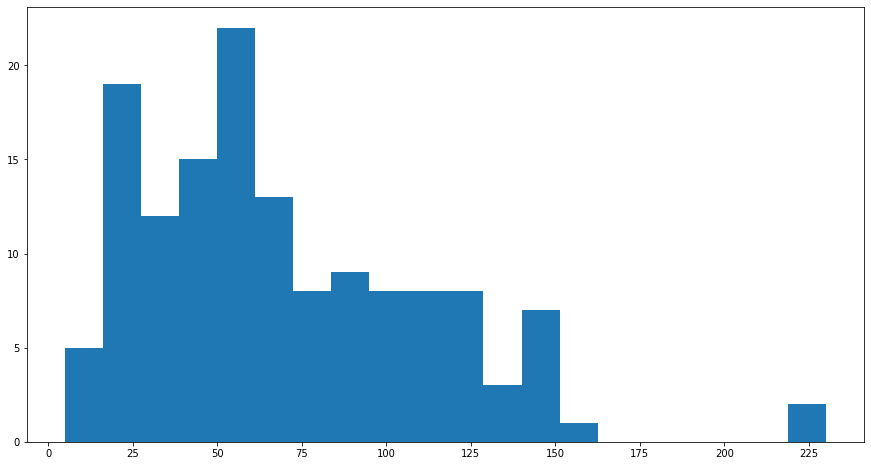

In [48]:
import matplotlib.pyplot as plt 

plt.hist(raw_data['answer_length'].values, bins=20)
plt.rcParams["figure.figsize"] = [8,15]
plt.xticks(np.arange(0, 250, step=25))
plt.show()

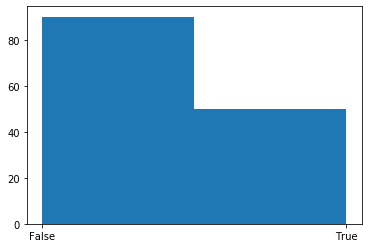

In [25]:
plt.hist(raw_data['correct'],bins=2)
plt.xticks(np.arange(2), ['False', 'True'])
plt.show()

# Training Basic Model

In [142]:
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(entry_point='source/train.py', 
                       role=role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       framework_version='1.12.0', 
                       py_version='py3',
                       script_mode=True,
                       hyperparameters = {
                        'epochs': 200,
                        'embedding_size': 30,
                        'flatten': 0,   
                        'lstm_dim_1': 100,
                        'lstm_dim_2': 0,
                        'dropout': 0.2
                    })

In [146]:
%%time
# Train estimator on S3 training data
estimator.fit(input_data)

2019-06-29 00:27:21 Starting - Starting the training job...
2019-06-29 00:27:22 Starting - Launching requested ML instances......
2019-06-29 00:28:24 Starting - Preparing the instances for training...
2019-06-29 00:29:19 Downloading - Downloading input data...
2019-06-29 00:29:51 Training - Training image download completed. Training in progress..
2019-06-29 00:29:54,022 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-06-29 00:29:54,030 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-06-29 00:29:54,349 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-06-29 00:29:54,364 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-06-29 00:29:54,375 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_

# Hypertuning Model

In [125]:
# First, make sure to import the relevant objects used to construct the tuner
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

tf_hyperparameter_tuner = HyperparameterTuner(estimator = estimator, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'Validation_accuracy', # The metric used to compare trained models.
                                               objective_type = 'Maximize', # Whether we wish to minimize or maximize the metric.
                                               metric_definitions = [{'Name': 'Validation_loss', 
                                                                      'Regex': 'Validation_loss:(.*?);'},
                                                                     {'Name': 'Validation_accuracy', 
                                                                      'Regex': 'Validation_accuracy:(.*?);'}
                                                                    ],
                                               max_jobs = 18, # The total number of models to train
                                               max_parallel_jobs = 6, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'dropout': ContinuousParameter(0.1, 0.4),
                                                    'embedding_size': IntegerParameter(20, 100),
                                                    'lstm_dim_1': IntegerParameter(50, 150)
                                               })


In [126]:
# tf_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})
tf_hyperparameter_tuner.fit(input_data)

In [127]:
tf_hyperparameter_tuner.wait()

...................................................................................................................................................................................................!


In [129]:
tf_hyperparameter_tuner.best_training_job()

'sagemaker-tensorflow-190625-2206-006-877d978f'

In [130]:
# Reload an existing trained estimator
training_job_name = tf_hyperparameter_tuner.best_training_job()
estimator = TensorFlow.attach(training_job_name)

2019-06-25 22:12:05 Starting - Preparing the instances for training
2019-06-25 22:12:05 Downloading - Downloading input data
2019-06-25 22:12:05 Training - Training image download completed. Training in progress.
2019-06-25 22:12:05 Uploading - Uploading generated training model
2019-06-25 22:12:05 Completed - Training job completed2019-06-25 22:10:04,881 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-06-25 22:10:04,882 sagemaker-containers INFO     Failed to parse hyperparameter _tuning_objective_metric value Validation_accuracy to Json.
Returning the value itself
2019-06-25 22:10:04,887 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-06-25 22:10:04,898 sagemaker_tensorflow_container.training INFO     Appending the training job name to model_dir: s3://sagemaker-us-east-1-399712746635/sagemaker-tensorflow-scriptmode-2019-06-23-00-14-46-505/model/sagemaker-tensorflow-190625-2206-006-877d978f/model
2019-06-2

In [131]:
predictor = estimator.deploy(initial_instance_count=1,
                             # instance_type='ml.c5.xlarge',
                             instance_type='ml.t2.medium',
                             endpoint_type='tensorflow-serving')

--------------------------------------------------------------------------------------------------!

## Load and Evaluate Test Data

In [132]:
import numpy as np
def evaluate(predictor, test_features, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # rounding and squeezing array
    test_preds = np.squeeze(predictor.predict(test_features)['predictions'])
    # Normalized to range 0 to 1
    min_red = test_y_preds.min()
    max_pred = test_y_preds.max()
    test_y_preds = (test_y_preds - min_pred) / (max_pred - min_pred)
    test_preds = np.round(test_preds)    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # print metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actuals'], colnames=['predictions']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return tp, fp, fn, tn, precision, recall, accuracy

In [133]:
test_data = pd.read_csv(os.path.join(data_dir, "test.csv"), header=None, names=None)
test_y = test_data.iloc[:, 0].values
test_x = test_data.iloc[:, 1:].values

In [134]:
# First: generate predicted, class labels
test_y_preds = np.squeeze(predictor.predict(test_x)['predictions'])
#normalize to 0 - 1
min_red = test_y_preds.min()
max_pred = test_y_preds.max()
test_y_preds = (test_y_preds - min_pred) / (max_pred - min_pred)
print(test_y_preds)    

[ 4.10960932e-03 -6.35614264e-03  4.46019164e-03 -1.69594516e-02
  8.16530986e-01  4.69173840e-01  4.80202937e-03  5.49756554e-03
 -2.61269622e-01  8.24399174e-03  8.47077669e-01  7.94946052e-03
 -1.51907646e-02  4.63883263e-01  9.80572975e-01  9.77340007e-01
  9.80397694e-01  9.80134772e-01  1.07523468e-01 -6.77400382e-03
  5.53131695e-02 -1.25312585e-01  1.00000000e+00  4.77586375e-03
  1.68725899e-01  5.86324154e-02  7.74893857e-01  6.41065516e-01
  1.00313559e-02  9.62643633e-01  4.65057648e-03  1.67205819e-02
  9.95199237e-01  1.02664278e-02  1.36930822e-03  4.46518716e-03
  5.48881120e-03  4.36334865e-03 -1.99875355e-03  1.39826861e-02
  2.75562848e-02  2.72994001e-04  8.65174502e-02]


In [137]:
# Second: calculate the test accuracy
tp, fp, fn, tn, precision, recall, accuracy = evaluate(predictor, test_x, test_y)

## print out the array of predicted and true labels, if you want
results = pd.concat([pd.DataFrame(test_y_preds), pd.DataFrame(np.round(test_y_preds)), pd.DataFrame(test_y)], axis=1)
results.columns = ['raw_predicted','predicted','actual']
incorrect_results = results[results['predicted'] != results['actual']]
print(incorrect_results)

predictions  0.0  1.0
actuals              
0.0           24    2
1.0            8    9

Recall:     0.529
Precision:  0.818
Accuracy:   0.767

    raw_predicted  predicted  actual
1       -0.006356       -0.0     1.0
5        0.469174        0.0     1.0
8       -0.261270       -0.0     1.0
15       0.977340        1.0     0.0
17       0.980135        1.0     0.0
19      -0.006774       -0.0     1.0
21      -0.125313       -0.0     1.0
24       0.168726        0.0     1.0
38      -0.001999       -0.0     1.0
41       0.000273        0.0     1.0
